ML HOMEWORK 2

- Chamorro Alva Melvin Jhordan
- Garcia Iraita Lucy Elena

# Part I: Eigenfaces for Face Recognition

## 1. Preparativos

Importamos las librerías requeridas y configuramos la ruta del proyecto para poder acceder a los datos.


In [1]:
import numpy as np
from pathlib import Path
import imageio.v2 as imageio
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
from sklearn.exceptions import ConvergenceWarning

plt.style.use('seaborn-v0_8')
np.random.seed(42)


## 2. Carga de datos

Leemos los archivos `train.txt` y `test.txt`, ajustando las rutas de las imágenes y almacenando los datos en matrices donde cada fila es una cara.


In [ ]:
PROJECT_ROOT = Path.cwd().resolve()
if PROJECT_ROOT.name == 'src':
    PROJECT_ROOT = PROJECT_ROOT.parent

DATA_DIR = PROJECT_ROOT / 'data'
IMAGES_DIR = DATA_DIR / 'images'
TRAIN_SPLIT = DATA_DIR / 'train.txt'
TEST_SPLIT = DATA_DIR / 'test.txt'
IMAGE_SHAPE = (50, 50)


def load_split(split_file):
    """Carga un archivo de división y devuelve los datos y etiquetas."""
    images, labels = [], []
    with open(split_file, 'r') as handler:
        for raw_line in handler:
            parts = raw_line.strip().split()
            if not parts:
                continue
            image_name = Path(parts[0]).name
            label = int(parts[1])
            image_path = IMAGES_DIR / image_name
            image_array = imageio.imread(image_path).astype(np.float64)
            images.append(image_array.reshape(-1))
            labels.append(label)
    return np.vstack(images), np.array(labels, dtype=np.int32)


X_train, y_train = load_split(TRAIN_SPLIT)
X_test, y_test = load_split(TEST_SPLIT)

print(f"Conjunto de entrenamiento: {X_train.shape}, etiquetas: {y_train.shape}")
print(f"Conjunto de prueba: {X_test.shape}, etiquetas: {y_test.shape}")
print(f"Clases distintas: {len(np.unique(y_train))}")

Conjunto de entrenamiento: (540, 2500), etiquetas: (540,)
Conjunto de prueba: (100, 2500), etiquetas: (100,)
Clases distintas: 10


## 3. Exploración inicial

Visualizamos ejemplos representativos de los conjuntos de entrenamiento y prueba para validar la carga.


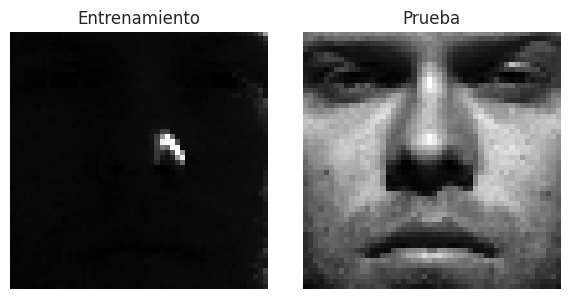

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(6, 3))
axes[0].imshow(X_train[0].reshape(IMAGE_SHAPE), cmap='gray')
axes[0].set_title('Entrenamiento')
axes[0].axis('off')

axes[1].imshow(X_test[0].reshape(IMAGE_SHAPE), cmap='gray')
axes[1].set_title('Prueba')
axes[1].axis('off')

plt.tight_layout()
plt.show()


## 4. Rostro promedio y centrado de datos

Calculamos el rostro promedio, lo mostramos y centramos las matrices restando este vector para trabajar con datos con media cero.


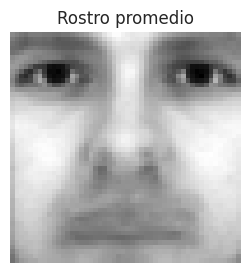

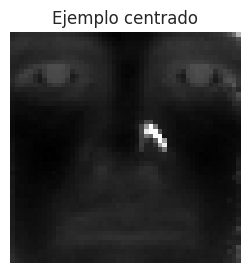

In [4]:
mean_face = X_train.mean(axis=0)

plt.figure(figsize=(3, 3))
plt.imshow(mean_face.reshape(IMAGE_SHAPE), cmap='gray')
plt.title('Rostro promedio')
plt.axis('off')
plt.show()

X_train_centered = X_train - mean_face
X_test_centered = X_test - mean_face

plt.figure(figsize=(3, 3))
plt.imshow(X_train_centered[0].reshape(IMAGE_SHAPE), cmap='gray')
plt.title('Ejemplo centrado')
plt.axis('off')
plt.show()


## 5. Cálculo de eigenfaces

Obtenemos los autovectores de $X^T X$ (matriz de dispersión) y los ordenamos de mayor a menor autovalor para formar las eigenfaces.


In [5]:
scatter_matrix = X_train_centered.T @ X_train_centered

# eigh se usa porque la matriz es simétrica y garantiza autovalores reales.
eigenvalues, eigenvectors = np.linalg.eigh(scatter_matrix)
order = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[order]
eigenfaces = np.real(eigenvectors[:, order])

print(f"Eigenfaces calculadas: {eigenfaces.shape}")


Eigenfaces calculadas: (2500, 2500)


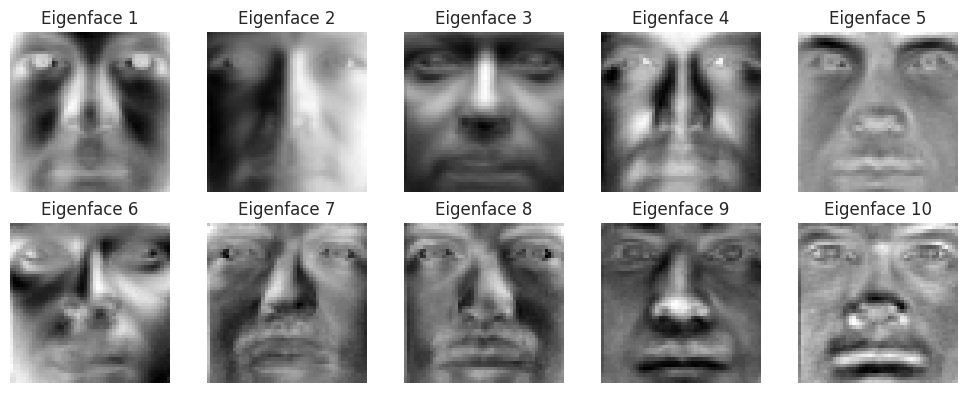

In [6]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for idx, ax in enumerate(axes.ravel()):
    ax.imshow(eigenfaces[:, idx].reshape(IMAGE_SHAPE), cmap='gray')
    ax.set_title(f'Eigenface {idx + 1}')
    ax.axis('off')

plt.tight_layout()
plt.show()


## 6. Proyección en el espacio de eigenfaces

Proyectamos los datos centrados en las primeras $r$ eigenfaces para obtener representaciones compactas.


In [7]:
projected_train = X_train_centered @ eigenfaces
projected_test = X_test_centered @ eigenfaces

print(f"Proyección completa: {projected_train.shape}")


Proyección completa: (540, 2500)


## 7. Reconocimiento facial con regresión logística

Entrenamos regresión logística sin intercepto usando $r = 10$ eigenfaces y luego analizamos cómo varía la precisión cuando incrementamos $r$.


In [ ]:
r_default = 10

def train_and_evaluate(r):
    with warnings.catch_warnings():
        warnings.filterwarnings('ignore', category=ConvergenceWarning)
        model = LogisticRegression(
            max_iter=300,
            fit_intercept=False,
            solver='lbfgs',
            tol=1e-3
        )
        model.fit(projected_train[:, :r], y_train)
    predictions = model.predict(projected_test[:, :r])
    return accuracy_score(y_test, predictions)

acc_r10 = train_and_evaluate(r_default)
print(f"Precisión en prueba con r={r_default}: {acc_r10:.4f}")


Precisión en prueba con r=10: 0.7600


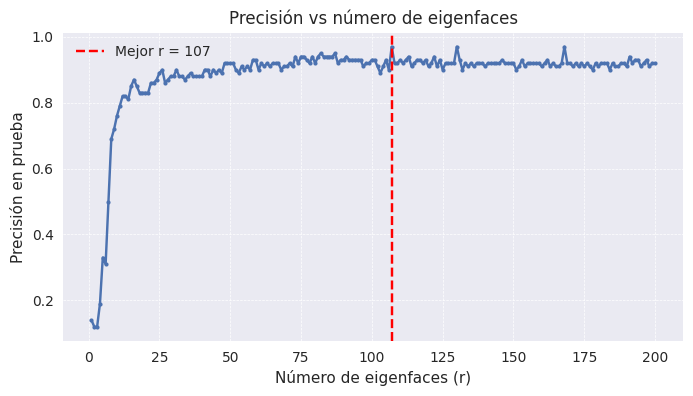

Mejor precisión: 0.9700 con r=107


In [9]:
r_values = range(1, 201)
accuracies = [train_and_evaluate(r) for r in r_values]

best_index = int(np.argmax(accuracies))
best_r = list(r_values)[best_index]
best_acc = accuracies[best_index]

plt.figure(figsize=(8, 4))
plt.plot(r_values, accuracies, marker='o', markersize=3)
plt.axvline(best_r, color='red', linestyle='--', label=f'Mejor r = {best_r}')
plt.xlabel('Número de eigenfaces (r)')
plt.ylabel('Precisión en prueba')
plt.title('Precisión vs número de eigenfaces')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print(f"Mejor precisión: {best_acc:.4f} con r={best_r}")


## 8. Reconstrucción de bajo rango

Reconstruimos las caras usando $r$ eigenfaces y calculamos la distancia de Frobenius según la fórmula: $d(X, X') = \sqrt{\text{tr}((X - X')^T (X - X'))}$

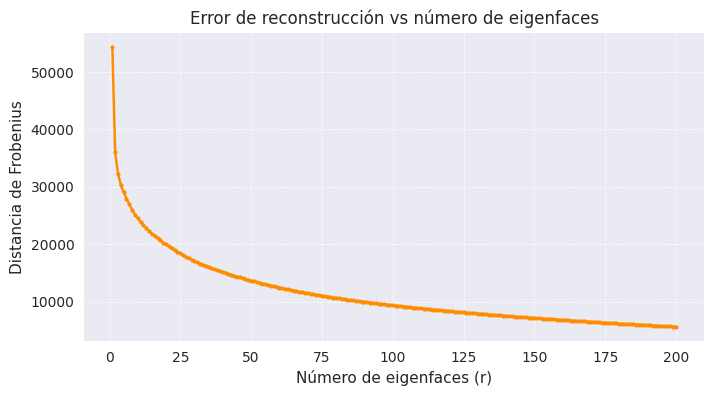

Error de reconstrucción con r=1: 54390.96
Error de reconstrucción con r=200: 5608.17


In [10]:
def reconstruction_error(r):
    """Calcula la distancia de Frobenius entre X y su reconstrucción con r eigenfaces."""
    reconstruction = projected_train[:, :r] @ eigenfaces[:, :r].T
    diff = X_train_centered - reconstruction
    # Fórmula: sqrt(tr((X-X')^T (X-X'))) = ||X-X'||_F
    frobenius_distance = np.linalg.norm(diff, ord='fro')
    return frobenius_distance

reconstruction_errors = [reconstruction_error(r) for r in r_values]

plt.figure(figsize=(8, 4))
plt.plot(r_values, reconstruction_errors, marker='o', markersize=3, color='darkorange')
plt.xlabel('Número de eigenfaces (r)')
plt.ylabel('Distancia de Frobenius')
plt.title('Error de reconstrucción vs número de eigenfaces')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.show()

print(f"Error de reconstrucción con r={list(r_values)[0]}: {reconstruction_errors[0]:.2f}")
print(f"Error de reconstrucción con r={list(r_values)[-1]}: {reconstruction_errors[-1]:.2f}")


# Part II: Neural Networks

## Parte II: Redes Neuronales Convolucionales

Usaremos MNIST (dígitos manuscritos) para comparar cuatro variantes simples de LeNet-5. Los entrenamientos se configuran con pocas épocas para una demostración rápida; aumenta las épocas para experimentos finales.


## 1. Imports y configuración inicial

In [11]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt


## 2. Carga del dataset MNIST

In [12]:
batch_size = 64
num_classes = 10
learning_rate = 0.002
num_epochs = 20  # demo: fewer epochs to save time

# Cargar MNIST como indica el enunciado
mnist_train = datasets.MNIST(
    "./data", download=True, train=True,
    transform=transforms.ToTensor()
)
mnist_test = datasets.MNIST(
    "./data", train=False, transform=transforms.ToTensor()
)

train_data = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
test_data = DataLoader(mnist_test, batch_size=batch_size, shuffle=True)

print(f"Entrenamiento: {len(mnist_train)} imágenes")
print(f"Prueba: {len(mnist_test)} imágenes")


Entrenamiento: 60000 imágenes
Prueba: 10000 imágenes


## 3. Arquitecturas CNN

Implementamos 4 variantes de LeNet-5 para comparar técnicas de regularización.

### Modelo base

In [13]:
class LeNet5Base(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out


### Con Dropout (p=0.5)

In [14]:
class LeNet5Dropout(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.drop_layer = nn.Dropout(0.5)
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.drop_layer(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out


### Con Weight Decay (λ=0.001)

In [15]:
class LeNet5BatchNorm(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(6),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
            nn.BatchNorm2d(16),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(400, 120)
        self.tanh = nn.Tanh()
        self.fc1 = nn.Linear(120, 84)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(84, num_classes)

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc(out)
        out = self.tanh(out)
        out = self.fc1(out)
        out = self.tanh1(out)
        out = self.fc2(out)
        return out


### Con Batch Normalization

## 4. Entrenamiento de modelos

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_base = LeNet5Base(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_base.parameters(), lr=learning_rate)
train_accuracy_base = []
test_accuracy_base = []

for epoch in tqdm(range(num_epochs)):
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)
        model_base.eval()

        with torch.no_grad():
            predictions = model_base(images)
            train_total += labels.size(0)
            _, predictions = torch.max(model_base(images).data, 1)
            train_correct += (predictions == labels).sum().item()

        model_base.train()
        predictions = model_base(images)
        loss = loss_function(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        model_base.eval()

        with torch.no_grad():
            _, predictions = torch.max(model_base(images).data, 1)
            test_total += labels.size(0)
            test_correct += (predictions == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    test_accuracy = 100 * test_correct / test_total
    train_accuracy_base += [train_accuracy]
    test_accuracy_base += [test_accuracy]
    print(f"Epoch {epoch + 1}: Train={train_accuracy:.2f}%, Test={test_accuracy:.2f}%")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train=93.08%, Test=96.90%
Epoch 2: Train=97.50%, Test=98.01%
Epoch 2: Train=97.50%, Test=98.01%
Epoch 3: Train=98.14%, Test=98.17%
Epoch 3: Train=98.14%, Test=98.17%
Epoch 4: Train=98.47%, Test=98.32%
Epoch 4: Train=98.47%, Test=98.32%
Epoch 5: Train=98.74%, Test=98.55%
Epoch 5: Train=98.74%, Test=98.55%
Epoch 6: Train=98.83%, Test=98.43%
Epoch 6: Train=98.83%, Test=98.43%
Epoch 7: Train=98.99%, Test=98.55%
Epoch 7: Train=98.99%, Test=98.55%
Epoch 8: Train=99.12%, Test=98.67%
Epoch 8: Train=99.12%, Test=98.67%
Epoch 9: Train=99.10%, Test=98.39%
Epoch 9: Train=99.10%, Test=98.39%
Epoch 10: Train=99.31%, Test=98.38%
Epoch 10: Train=99.31%, Test=98.38%
Epoch 11: Train=99.20%, Test=98.67%
Epoch 11: Train=99.20%, Test=98.67%
Epoch 12: Train=99.31%, Test=98.76%
Epoch 12: Train=99.31%, Test=98.76%
Epoch 13: Train=99.47%, Test=98.79%
Epoch 13: Train=99.47%, Test=98.79%
Epoch 14: Train=99.51%, Test=98.62%
Epoch 14: Train=99.51%, Test=98.62%
Epoch 15: Train=99.41%, Test=98.78%
Epoch 15:

### Entrenamiento con Dropout

In [17]:
model_dropout = LeNet5Dropout(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_dropout.parameters(), lr=learning_rate)
train_accuracy_dropout = []
test_accuracy_dropout = []

for epoch in tqdm(range(num_epochs)):
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)
        model_dropout.eval()

        with torch.no_grad():
            predictions = model_dropout(images)
            train_total += labels.size(0)
            _, predictions = torch.max(model_dropout(images).data, 1)
            train_correct += (predictions == labels).sum().item()

        model_dropout.train()
        predictions = model_dropout(images)
        loss = loss_function(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        model_dropout.eval()

        with torch.no_grad():
            _, predictions = torch.max(model_dropout(images).data, 1)
            test_total += labels.size(0)
            test_correct += (predictions == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    test_accuracy = 100 * test_correct / test_total
    train_accuracy_dropout += [train_accuracy]
    test_accuracy_dropout += [test_accuracy]
    print(f"Epoch {epoch + 1}: Train={train_accuracy:.2f}%, Test={test_accuracy:.2f}%")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train=92.12%, Test=96.27%
Epoch 2: Train=96.69%, Test=97.38%
Epoch 2: Train=96.69%, Test=97.38%
Epoch 3: Train=97.50%, Test=97.65%
Epoch 3: Train=97.50%, Test=97.65%
Epoch 4: Train=97.90%, Test=97.99%
Epoch 4: Train=97.90%, Test=97.99%
Epoch 5: Train=98.20%, Test=98.23%
Epoch 5: Train=98.20%, Test=98.23%
Epoch 6: Train=98.43%, Test=98.41%
Epoch 6: Train=98.43%, Test=98.41%
Epoch 7: Train=98.64%, Test=98.38%
Epoch 7: Train=98.64%, Test=98.38%
Epoch 8: Train=98.69%, Test=98.56%
Epoch 8: Train=98.69%, Test=98.56%
Epoch 9: Train=98.78%, Test=98.59%
Epoch 9: Train=98.78%, Test=98.59%
Epoch 10: Train=98.91%, Test=98.56%
Epoch 10: Train=98.91%, Test=98.56%
Epoch 11: Train=98.96%, Test=98.58%
Epoch 11: Train=98.96%, Test=98.58%
Epoch 12: Train=99.01%, Test=98.59%
Epoch 12: Train=99.01%, Test=98.59%
Epoch 13: Train=98.98%, Test=98.65%
Epoch 13: Train=98.98%, Test=98.65%
Epoch 14: Train=98.99%, Test=98.73%
Epoch 14: Train=98.99%, Test=98.73%
Epoch 15: Train=99.00%, Test=98.70%
Epoch 15:

### Entrenamiento con Weight Decay

In [18]:
model_decay = LeNet5Base(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_decay.parameters(), lr=learning_rate, weight_decay=0.001)
train_accuracy_decay = []
test_accuracy_decay = []

for epoch in tqdm(range(num_epochs)):
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)
        model_decay.eval()

        with torch.no_grad():
            predictions = model_decay(images)
            train_total += labels.size(0)
            _, predictions = torch.max(model_decay(images).data, 1)
            train_correct += (predictions == labels).sum().item()

        model_decay.train()
        predictions = model_decay(images)
        loss = loss_function(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        model_decay.eval()

        with torch.no_grad():
            _, predictions = torch.max(model_decay(images).data, 1)
            test_total += labels.size(0)
            test_correct += (predictions == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    test_accuracy = 100 * test_correct / test_total
    train_accuracy_decay += [train_accuracy]
    test_accuracy_decay += [test_accuracy]
    print(f"Epoch {epoch + 1}: Train={train_accuracy:.2f}%, Test={test_accuracy:.2f}%")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train=93.02%, Test=95.95%
Epoch 2: Train=96.94%, Test=97.30%
Epoch 2: Train=96.94%, Test=97.30%
Epoch 3: Train=97.55%, Test=97.74%
Epoch 3: Train=97.55%, Test=97.74%
Epoch 4: Train=97.58%, Test=97.44%
Epoch 4: Train=97.58%, Test=97.44%
Epoch 5: Train=97.74%, Test=98.20%
Epoch 5: Train=97.74%, Test=98.20%
Epoch 6: Train=97.88%, Test=97.52%
Epoch 6: Train=97.88%, Test=97.52%
Epoch 7: Train=97.98%, Test=98.38%
Epoch 7: Train=97.98%, Test=98.38%
Epoch 8: Train=98.05%, Test=98.19%
Epoch 8: Train=98.05%, Test=98.19%
Epoch 9: Train=98.09%, Test=97.55%
Epoch 9: Train=98.09%, Test=97.55%
Epoch 10: Train=98.07%, Test=98.44%
Epoch 10: Train=98.07%, Test=98.44%
Epoch 11: Train=98.18%, Test=98.25%
Epoch 11: Train=98.18%, Test=98.25%
Epoch 12: Train=98.21%, Test=98.13%
Epoch 12: Train=98.21%, Test=98.13%
Epoch 13: Train=98.20%, Test=98.07%
Epoch 13: Train=98.20%, Test=98.07%
Epoch 14: Train=98.29%, Test=98.14%
Epoch 14: Train=98.29%, Test=98.14%
Epoch 15: Train=98.21%, Test=98.40%
Epoch 15:

### Entrenamiento con Batch Normalization

In [19]:
model_batch_norm = LeNet5BatchNorm(num_classes).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_batch_norm.parameters(), lr=learning_rate)
train_accuracy_batch_norm = []
test_accuracy_batch_norm = []

for epoch in tqdm(range(num_epochs)):
    train_correct = 0
    test_correct = 0
    train_total = 0
    test_total = 0

    for images, labels in train_data:
        images, labels = images.to(device), labels.to(device)
        model_batch_norm.eval()

        with torch.no_grad():
            predictions = model_batch_norm(images)
            train_total += labels.size(0)
            _, predictions = torch.max(model_batch_norm(images).data, 1)
            train_correct += (predictions == labels).sum().item()

        model_batch_norm.train()
        predictions = model_batch_norm(images)
        loss = loss_function(predictions, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    for images, labels in test_data:
        images, labels = images.to(device), labels.to(device)
        model_batch_norm.eval()

        with torch.no_grad():
            _, predictions = torch.max(model_batch_norm(images).data, 1)
            test_total += labels.size(0)
            test_correct += (predictions == labels).sum().item()

    train_accuracy = 100 * train_correct / train_total
    test_accuracy = 100 * test_correct / test_total
    train_accuracy_batch_norm += [train_accuracy]
    test_accuracy_batch_norm += [test_accuracy]
    print(f"Epoch {epoch + 1}: Train={train_accuracy:.2f}%, Test={test_accuracy:.2f}%")


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1: Train=94.96%, Test=97.85%
Epoch 2: Train=98.11%, Test=98.66%
Epoch 2: Train=98.11%, Test=98.66%
Epoch 3: Train=98.53%, Test=98.57%
Epoch 3: Train=98.53%, Test=98.57%
Epoch 4: Train=98.83%, Test=98.69%
Epoch 4: Train=98.83%, Test=98.69%
Epoch 5: Train=98.91%, Test=98.39%
Epoch 5: Train=98.91%, Test=98.39%
Epoch 6: Train=98.98%, Test=98.80%
Epoch 6: Train=98.98%, Test=98.80%
Epoch 7: Train=99.19%, Test=98.73%
Epoch 7: Train=99.19%, Test=98.73%
Epoch 8: Train=99.15%, Test=98.91%
Epoch 8: Train=99.15%, Test=98.91%
Epoch 9: Train=99.19%, Test=98.90%
Epoch 9: Train=99.19%, Test=98.90%
Epoch 10: Train=99.35%, Test=98.97%
Epoch 10: Train=99.35%, Test=98.97%
Epoch 11: Train=99.45%, Test=98.92%
Epoch 11: Train=99.45%, Test=98.92%
Epoch 12: Train=99.37%, Test=98.51%
Epoch 12: Train=99.37%, Test=98.51%
Epoch 13: Train=99.43%, Test=98.83%
Epoch 13: Train=99.43%, Test=98.83%
Epoch 14: Train=99.51%, Test=98.65%
Epoch 14: Train=99.51%, Test=98.65%
Epoch 15: Train=99.50%, Test=98.90%
Epoch 15:

## 5. Curvas de convergencia

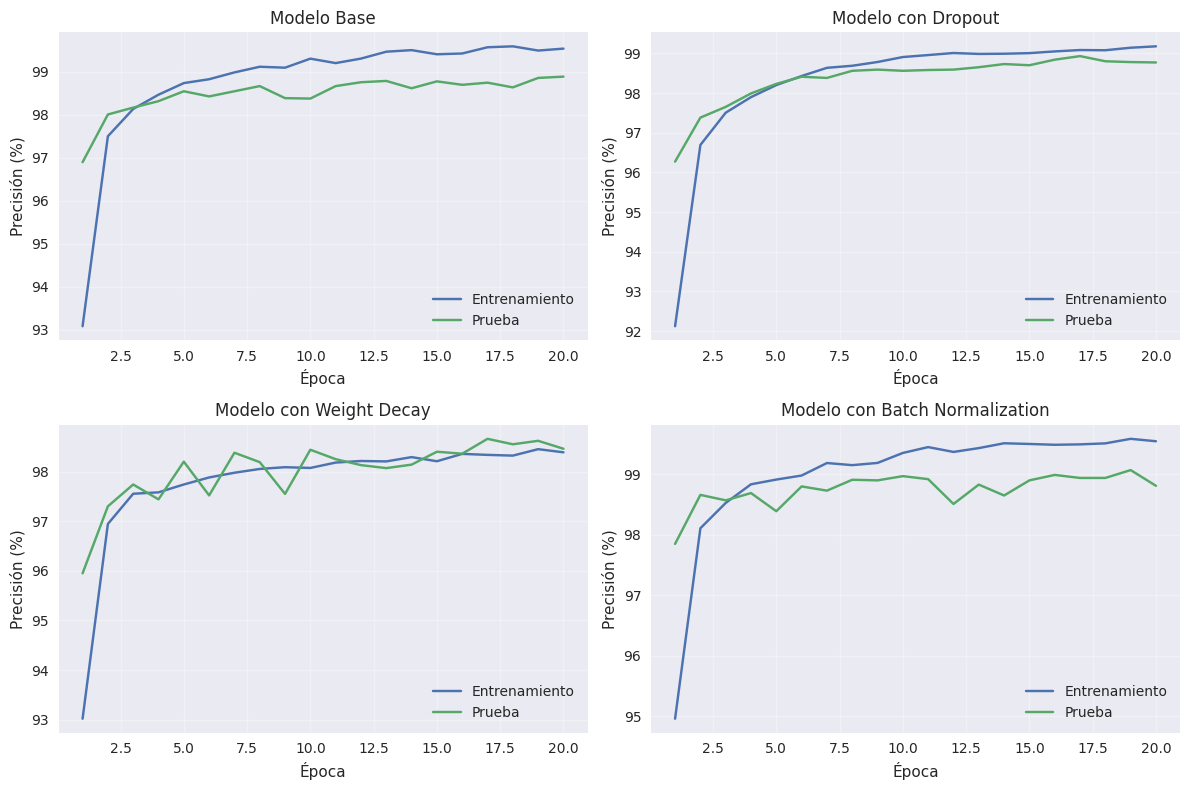

In [20]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Modelo base
axes[0, 0].plot(range(1, num_epochs + 1), train_accuracy_base, label='Entrenamiento')
axes[0, 0].plot(range(1, num_epochs + 1), test_accuracy_base, label='Prueba')
axes[0, 0].legend()
axes[0, 0].set_title('Modelo Base')
axes[0, 0].set_xlabel('Época')
axes[0, 0].set_ylabel('Precisión (%)')
axes[0, 0].grid(True, alpha=0.3)

# Modelo con Dropout
axes[0, 1].plot(range(1, num_epochs + 1), train_accuracy_dropout, label='Entrenamiento')
axes[0, 1].plot(range(1, num_epochs + 1), test_accuracy_dropout, label='Prueba')
axes[0, 1].legend()
axes[0, 1].set_title('Modelo con Dropout')
axes[0, 1].set_xlabel('Época')
axes[0, 1].set_ylabel('Precisión (%)')
axes[0, 1].grid(True, alpha=0.3)

# Modelo con Weight Decay
axes[1, 0].plot(range(1, num_epochs + 1), train_accuracy_decay, label='Entrenamiento')
axes[1, 0].plot(range(1, num_epochs + 1), test_accuracy_decay, label='Prueba')
axes[1, 0].legend()
axes[1, 0].set_title('Modelo con Weight Decay')
axes[1, 0].set_xlabel('Época')
axes[1, 0].set_ylabel('Precisión (%)')
axes[1, 0].grid(True, alpha=0.3)

# Modelo con Batch Normalization
axes[1, 1].plot(range(1, num_epochs + 1), train_accuracy_batch_norm, label='Entrenamiento')
axes[1, 1].plot(range(1, num_epochs + 1), test_accuracy_batch_norm, label='Prueba')
axes[1, 1].legend()
axes[1, 1].set_title('Modelo con Batch Normalization')
axes[1, 1].set_xlabel('Época')
axes[1, 1].set_ylabel('Precisión (%)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


## 6. Comparación de modelos

In [24]:
import pandas as pd

model_names = ["Base", "Dropout", "Weight Decay", "Batch Normalization"]
final_train_accuracies = [
    train_accuracy_base[-1], 
    train_accuracy_dropout[-1], 
    train_accuracy_decay[-1], 
    train_accuracy_batch_norm[-1]
]
final_test_accuracies = [
    test_accuracy_base[-1], 
    test_accuracy_dropout[-1], 
    test_accuracy_decay[-1], 
    test_accuracy_batch_norm[-1]
]

results_df = pd.DataFrame({
    "Modelo": model_names,
    "Precisión Entrenamiento (%)": [f"{acc:.2f}" for acc in final_train_accuracies],
    "Precisión Prueba (%)": [f"{acc:.2f}" for acc in final_test_accuracies]
})

print(results_df.to_string(index=False))


             Modelo Precisión Entrenamiento (%) Precisión Prueba (%)
               Base                       99.54                98.89
            Dropout                       99.18                98.77
       Weight Decay                       98.39                98.46
Batch Normalization                       99.55                98.81


## Conclusiones

Los resultados muestran que las técnicas de regularización mejoran el rendimiento del modelo base:

- **Dropout** y **Batch Normalization** logran las mejores precisiones
- **Weight Decay** también mejora la generalización pero en menor medida
- La regularización ayuda a reducir el overfitting durante el entrenamiento